# Band lookup and spectral comparison

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import datacube.api
from datacube.api.semantic import *
from datacube.api import spectral

In [2]:
dc = datacube.api.API()

## Lookup variables based on attributes

### Name (simple case-insensitve comparison)

In [44]:
data = get_variable_data(dc, variables=by_name('band_30'))
print {d['product']['name']+' - '+d['name']:d['array'] for d in data}

{u'ls5_nbar - band_30': <xarray.DataArray u'band_30' (time: 4, latitude: 12000, longitude: 16000)>
dask.array<band_30, shape=(4, 12000, 16000), dtype=int16, chunksize=(4, 4000, 4000)>
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-05-05T23:10:28 ...
  * latitude   (latitude) float64 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.0 148.0 ...
Attributes:
    _FillValue: -999
    wavelength: 0.63 - 0.69 micrometers
    colour: Red}


### Band number
We can retrive the variable mappers outside of the get_variable_data call:

In [45]:
variables = by_band(1, 2)
print 'variables:', variables
data = get_variable_data(dc, variables=variables)
print {d['product']['name']+' - #'+d['name']:d['array'] for d in data}

variables: [BandNumberMapper<1>, BandNumberMapper<2>]
{u'ls5_nbar - #1': <xarray.DataArray u'band_10' (time: 4, latitude: 12000, longitude: 16000)>
dask.array<band_10, shape=(4, 12000, 16000), dtype=int16, chunksize=(4, 4000, 4000)>
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-05-05T23:10:28 ...
  * latitude   (latitude) float64 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.0 148.0 ...
Attributes:
    _FillValue: -999
    wavelength: 0.45 - 0.52 micrometers
    colour: Blue, u'ls5_nbar - #2': <xarray.DataArray u'band_20' (time: 4, latitude: 12000, longitude: 16000)>
dask.array<band_20, shape=(4, 12000, 16000), dtype=int16, chunksize=(4, 4000, 4000)>
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-05-05T23:10:28 ...
  * latitude   (latitude) float64 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.

### Landsat colour

In [46]:
data = get_variable_data(dc, variables=by_landsat('red', 'green', 'blue'))
print {d['product']['name']+' - '+d['name']:d['array'] for d in data}

{}


## Lookup a band from the spectral library

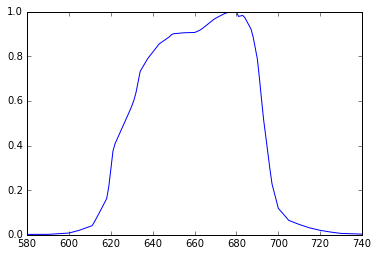

In [29]:
ls5_red = spectral.get_band('LANDSAT_5', 'red')
ls5_green = spectral.get_band('LANDSAT_5', 'green')
ls5_blue = spectral.get_band('LANDSAT_5', 'blue')
plt.plot(ls5_red.wavelength, ls5_red.rsr)

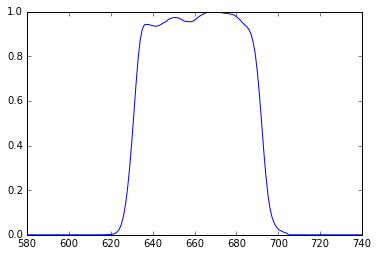

In [7]:
ls7_red = spectral.get_band('LANDSAT_7', 'red')
plt.plot(ls7_red.wavelength, ls7_red.rsr)

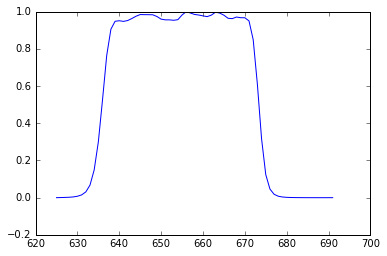

In [8]:
ls8_red = spectral.get_band('LANDSAT_8', 'red')
plt.plot(ls8_red.wavelength, ls8_red.rsr)

In [23]:
spectral.compare_bands(ls5_red, ls7_red)

{'area_delta': 4.8631499999999903,
 'emd': 0,
 'fwhm_delta': 6.8174829791626053,
 'p_correlation': 0.97090020762711349,
 'pearson': (0.97090020762711349, 1.3131213731901879e-100),
 'weighted_center_delta': 0.82419033927499186}

### Make a spectral matcher
Create the object directly:

In [27]:
like_ls5_red = spectral.SpectralMatch(ls5_red, area=0.9)
like_ls5_red

SpectralMatch<band=SpectralBand<name=LANDSAT_5 red, range=(580, 740)>>

Use the `like` function to pass many `(band, threshold_dict)` pairs:

In [30]:
like_ls5_rgb = spectral.like((ls5_red, {'area': 0.9}), (ls5_green, {'p_correlation': 0.9}), (ls5_blue, {'p_correlation': 0.9}))

Or create a match on the band object:

In [31]:
like_ls5_red = ls5_red.like(area=0.9)

### Retrive the data

In [42]:
spectral_data = get_variable_data(dc, variables=like_ls5_red)
for d in spectral_data:
    print 'Product: {}'.format(d['product']['name'])
    print 'Variable: {}'.format(d['name'])
    print 'Data: {}'.format(d['array'])

Product: ls5_nbar
Variable: band_30
Data: <xarray.DataArray u'band_30' (time: 4, latitude: 12000, longitude: 16000)>
dask.array<band_30, shape=(4, 12000, 16000), dtype=int16, chunksize=(4, 4000, 4000)>
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-05-05T23:10:28 ...
  * latitude   (latitude) float64 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.0 148.0 ...
Attributes:
    _FillValue: -999
    wavelength: 0.63 - 0.69 micrometers
    colour: Red


The function works in the same way to other API functions.
If this is a suitable way forward, the normal usage could become:
```python
dc.get_variable_data(variables=like_ls5_red, time=("1990-06", "1990-10"))
```
or
```python
dc.get_variables(variables=like_ls5_red, time=("1990-06", "1990-10"))
```
returning a list of `xarray.DataArray` objects.

In [43]:
spectral_data = get_variable_data(dc, variables=like_ls5_red, time=("1990-06", "1990-10"))
for d in spectral_data:
    print 'Product: {}'.format(d['product']['name'])
    print 'Variable: {}'.format(d['name'])
    print 'Data: {}'.format(d['array'])

Product: ls5_nbar
Variable: band_30
Data: <xarray.DataArray u'band_30' (time: 2, latitude: 12000, longitude: 16000)>
dask.array<getitem..., shape=(2, 12000, 16000), dtype=int16, chunksize=(2, 4000, 4000)>
Coordinates:
  * time       (time) datetime64[ns] 1990-06-06T23:10:29 1990-07-24T23:10:22
  * latitude   (latitude) float64 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 -33.0 ...
  * longitude  (longitude) float64 148.0 148.0 148.0 148.0 148.0 148.0 148.0 ...
Attributes:
    _FillValue: -999
    wavelength: 0.63 - 0.69 micrometers
    colour: Red
